# Make Diagnostic Plots for NA-CORDEX Zarr Stores

In [1]:
import xarray as xr
import numpy as np
import intake
import ast

import matplotlib.pyplot as plt

## Create and Connect to a Dask Distributed Cluster

In [2]:
import dask
from ncar_jobqueue import NCARCluster

num_jobs = 16
walltime = "3:00:00"
memory='23GB' 
#cluster = NCARCluster(cores=num_jobs, processes=1, memory=memory, walltime=walltime)
cluster = NCARCluster()
cluster.scale(jobs=num_jobs)

from distributed import Client
client = Client(cluster)
cluster

/glade/work/bonnland/miniconda3/envs/pangeo-cordex2/lib/python3.9/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43779 instead
  warnings.warn(


☝️ Link to Dask dashboard will appear above.

## Find and Obtain Data Using an Intake Catalog

#### Open catalog with list entries in "model" and produce a content summary

In [3]:
# Define the catalog description file location.   
catalog_url = "https://ncar-na-cordex.s3-us-west-2.amazonaws.com/catalogs/aws-na-cordex.json"

# Have the catalog interpret the "model" column as a list of values.
col = intake.open_esm_datastore(catalog_url, csv_kwargs={"converters": {"model": ast.literal_eval}},)
col

,unique
long_name,18
units,10
standard_name,10
spatial_domain,1
vertical_levels,1
start_time,3
end_time,4
model,26
frequency,1
variable,15


#### Open exploded catalog and produce a content summary

In [19]:
# Open collection description file
catalog_url = "https://ncar-na-cordex.s3-us-west-2.amazonaws.com/catalogs/aws-na-cordex-exploded.json"
col = intake.open_esm_datastore(catalog_url)
col

,unique
long_name,18
units,10
standard_name,10
spatial_domain,1
vertical_levels,1
start_time,3
end_time,4
model,26
frequency,1
variable,15


In [4]:
# Show the first few lines of the catalog
col.df.head(10)

,long_name,units,standard_name,spatial_domain,vertical_levels,start_time,end_time,model,frequency,variable,scenario,grid,bias_correction,spatial_resolution,path
0,Near-Surface Relative Humidity,%,relative_humidity,north_america,1,1979-01-01T12:00:00,2014-12-31T12:00:00,"[ERA-Int.CRCM5-UQAM, ERA-Int.CRCM5-OUR, ERA-In...",day,hurs,eval,NAM-22i,raw,0.25 deg,s3://ncar-na-cordex/day/hurs.eval.day.NAM-22i....
1,Near-Surface Relative Humidity,%,relative_humidity,north_america,1,1979-01-01T12:00:00,2015-12-31T12:00:00,"[ERA-Int.CRCM5-UQAM, ERA-Int.RegCM4, ERA-Int.H...",day,hurs,eval,NAM-44i,raw,0.50 deg,s3://ncar-na-cordex/day/hurs.eval.day.NAM-44i....
2,Near-Surface Relative Humidity,%,relative_humidity,north_america,1,1949-01-01T12:00:00,2100-12-31T12:00:00,[CanESM2.CanRCM4],day,hurs,hist-rcp45,NAM-22i,mbcn-Daymet,0.25 deg,s3://ncar-na-cordex/day/hurs.hist-rcp45.day.NA...
3,Near-Surface Relative Humidity,%,relative_humidity,north_america,1,1949-01-01T12:00:00,2100-12-31T12:00:00,[CanESM2.CanRCM4],day,hurs,hist-rcp45,NAM-22i,mbcn-gridMET,0.25 deg,s3://ncar-na-cordex/day/hurs.hist-rcp45.day.NA...
4,Near-Surface Relative Humidity,%,relative_humidity,north_america,1,1949-01-01T12:00:00,2100-12-31T12:00:00,"[GFDL-ESM2M.CRCM5-OUR, CanESM2.CRCM5-OUR, CanE...",day,hurs,hist-rcp45,NAM-22i,raw,0.25 deg,s3://ncar-na-cordex/day/hurs.hist-rcp45.day.NA...
5,Near-Surface Relative Humidity,%,relative_humidity,north_america,1,1949-01-01T12:00:00,2100-12-31T12:00:00,"[MPI-ESM-LR.CRCM5-UQAM, CanESM2.CRCM5-UQAM, EC...",day,hurs,hist-rcp45,NAM-44i,mbcn-Daymet,0.50 deg,s3://ncar-na-cordex/day/hurs.hist-rcp45.day.NA...
6,Near-Surface Relative Humidity,%,relative_humidity,north_america,1,1949-01-01T12:00:00,2100-12-31T12:00:00,"[MPI-ESM-LR.CRCM5-UQAM, CanESM2.CRCM5-UQAM, EC...",day,hurs,hist-rcp45,NAM-44i,mbcn-gridMET,0.50 deg,s3://ncar-na-cordex/day/hurs.hist-rcp45.day.NA...
7,Near-Surface Relative Humidity,%,relative_humidity,north_america,1,1949-01-01T12:00:00,2100-12-31T12:00:00,"[MPI-ESM-LR.CRCM5-UQAM, CanESM2.CRCM5-UQAM, EC...",day,hurs,hist-rcp45,NAM-44i,raw,0.50 deg,s3://ncar-na-cordex/day/hurs.hist-rcp45.day.NA...
8,Near-Surface Relative Humidity,%,relative_humidity,north_america,1,1949-01-01T12:00:00,2100-12-31T12:00:00,"[MPI-ESM-MR.CRCM5-UQAM, GEMatm-Can.CRCM5-UQAM,...",day,hurs,hist-rcp85,NAM-22i,mbcn-Daymet,0.25 deg,s3://ncar-na-cordex/day/hurs.hist-rcp85.day.NA...
9,Near-Surface Relative Humidity,%,relative_humidity,north_america,1,1949-01-01T12:00:00,2100-12-31T12:00:00,"[MPI-ESM-MR.CRCM5-UQAM, GEMatm-Can.CRCM5-UQAM,...",day,hurs,hist-rcp85,NAM-22i,mbcn-gridMET,0.25 deg,s3://ncar-na-cordex/day/hurs.hist-rcp85.day.NA...


In [5]:
# Produce a catalog content summary.
import pprint

uniques = col.unique(
    columns=["variable", "scenario", "grid", "model", "bias_correction"]
)
pprint.pprint(uniques, compact=True, indent=4)

{   'bias_correction': {   'count': 3,
                           'values': ['raw', 'mbcn-gridMET', 'mbcn-Daymet']},
    'grid': {'count': 2, 'values': ['NAM-22i', 'NAM-44i']},
    'model': {   'count': 26,
                 'values': [   'ERA-Int.CanRCM4', 'MPI-ESM-MR.CRCM5-UQAM',
                               'GEMatm-Can.CRCM5-UQAM', 'ERA-Int.HIRHAM5',
                               'ERA-Int.WRF', 'EC-EARTH.HIRHAM5',
                               'MPI-ESM-LR.CRCM5-UQAM', 'GFDL-ESM2M.WRF',
                               'CanESM2.CanRCM4', 'MPI-ESM-LR.CRCM5-OUR',
                               'GEMatm-MPI.CRCM5-UQAM', 'HadGEM2-ES.RegCM4',
                               'GFDL-ESM2M.RegCM4', 'CanESM2.RCA4',
                               'ERA-Int.CRCM5-UQAM', 'EC-EARTH.RCA4',
                               'MPI-ESM-LR.RegCM4', 'HadGEM2-ES.WRF',
                               'ERA-Int.RCA4', 'CanESM2.CRCM5-OUR',
                               'CanESM2.CRCM5-UQAM', 'ERA-Int.RegCM4',
     

#### Load data into xarray using the catalog

In [6]:
data_var = 'temp'

col_subset = col.search(
    variable=data_var,
    grid="NAM-44i",
    scenario="eval",
    bias_correction="raw",
)

col_subset

,unique
long_name,1
units,1
standard_name,1
spatial_domain,1
vertical_levels,1
start_time,1
end_time,1
model,6
frequency,1
variable,1


In [7]:
col_subset.df

,long_name,units,standard_name,spatial_domain,vertical_levels,start_time,end_time,model,frequency,variable,scenario,grid,bias_correction,spatial_resolution,path
0,Near-Surface Air Temperature,degC,air_temperature,north_america,1,1979-01-01T12:00:00,2015-12-31T12:00:00,"[ERA-Int.CRCM5-UQAM, ERA-Int.RegCM4, ERA-Int.H...",day,temp,eval,NAM-44i,raw,0.50 deg,s3://ncar-na-cordex/day/temp.eval.day.NAM-44i....


In [8]:
# Load catalog entries for subset into a dictionary of xarray datasets, and open the first one.
dsets = col_subset.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, storage_options={"anon": True}
)
print(f"\nDataset dictionary keys:\n {dsets.keys()}")

# Load the first dataset and display a summary.
dataset_key = list(dsets.keys())[0]
ds = dsets[dataset_key]
ds


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.frequency.scenario.grid.bias_correction'



Dataset dictionary keys:
 dict_keys(['temp.day.eval.NAM-44i.raw'])


<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 129, lon: 300, member_id: 6, time: 13514)
Coordinates:
  * lat        (lat) float64 12.25 12.75 13.25 13.75 ... 74.75 75.25 75.75 76.25
  * lon        (lon) float64 -171.8 -171.2 -170.8 ... -23.25 -22.75 -22.25
  * member_id  (member_id) <U18 'ERA-Int.CRCM5-UQAM' ... 'ERA-Int.WRF'
  * time       (time) datetime64[ns] 1979-01-01T12:00:00 ... 2015-12-31T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(13514, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    temp       (member_id, time, lat, lon) float32 dask.array<chunksize=(4, 1000, 65, 150), meta=np.ndarray>
Attributes: (12/26)
    CORDEX_domain:                  NAM-44
    contact:                        {"ERA-Int.CRCM5-UQAM": "Winger.Katja@uqam...
    contact_note:                   {"ERA-Int.RegCM4": "Simulations by Ray Ar...
    creation_date:                  {"ERA-Int.CRCM5-UQAM": "2015-06-18T10:20:...
    driving_experiment:             {"ERA-Int.CRCM5-UQAM": "ECMWF-ERAINT, eva...
    driving_experiment_name:        evaluation
    ...                             ...
    tracking_id:                    {"ERA-Int.CRCM5-UQAM": "ad7169b6-a56e-4c7...
    version:                        {"ERA-Int.CRCM5-UQAM": "1.2", "ERA-Int.Re...
    zarr-dataset-reference:         For dataset documentation, see DOI https:...
    zarr-version:                   1.0
    intake_esm_varname:             ['temp']
    intake_esm_dataset_key:         temp.day.eval.NAM-44i.raw

## Functions for Plotting

#### Helper Function to Create a Single Map Plot

In [9]:
def plotMap(ax, map_slice, date_object=None, member_id=None):
    """Create a map plot on the given axes, with min/max as text"""

    ax.imshow(map_slice, origin='lower')

    minval = map_slice.min(dim = ['lat', 'lon'])
    maxval = map_slice.max(dim = ['lat', 'lon'])

    # Format values to have at least 4 digits of precision.
    ax.text(0.01, 0.03, "Min: %3g" % minval, transform=ax.transAxes, fontsize=12)
    ax.text(0.99, 0.03, "Max: %3g" % maxval, transform=ax.transAxes, fontsize=12, horizontalalignment='right')
    ax.set_xticks([])
    ax.set_yticks([])
    
    if date_object:
        ax.set_title(date_object.values.astype(str)[:10], fontsize=12)
        
    if member_id:
        ax.set_ylabel(member_id, fontsize=12)
        
    return ax

#### Helper Function for Finding Dates with Available Data

In [10]:
def getValidDateIndexes(member_slice):
    """Search for the first and last dates with finite values."""
    min_values = member_slice.min(dim = ['lat', 'lon'])
    is_finite = np.isfinite(min_values)
    finite_indexes = np.where(is_finite)

    start_index = finite_indexes[0][0]
    end_index = finite_indexes[0][-1]
    return start_index, end_index

#### Function Producing Maps of First, Middle, and Final Timesteps

In [28]:
def plot_first_mid_last(ds, data_var):
    """Plot the first, middle, and final time steps for several climate runs."""
    num_members_to_plot = 4
    member_names = ds.coords['member_id'].values[0:num_members_to_plot]
    
    figWidth = 18 
    figHeight = 12 
    numPlotColumns = 3
    fig, axs = plt.subplots(num_members_to_plot, numPlotColumns, figsize=(figWidth, figHeight), constrained_layout=True)

    for index in np.arange(num_members_to_plot):
        mem_id = member_names[index]
        data_slice = ds[data_var].sel(member_id=mem_id)
           
        start_index, end_index = getValidDateIndexes(data_slice)
        midDateIndex = np.floor(len(ds.time) / 2).astype(int)

        startDate = ds.time[start_index]
        first_step = data_slice.sel(time=startDate) 
        ax = axs[index, 0]
        plotMap(ax, first_step, startDate, mem_id)

        midDate = ds.time[midDateIndex]
        mid_step = data_slice.sel(time=midDate)   
        ax = axs[index, 1]
        plotMap(ax, mid_step, midDate)

        endDate = ds.time[end_index]
        last_step = data_slice.sel(time=endDate)            
        ax = axs[index, 2]
        plotMap(ax, last_step, endDate)

    return fig

#### Function Producing Statistical Map Plots

In [29]:
def plot_stat_maps(ds, data_var, store_name):
    """Plot the mean, min, max, and standard deviation values for several climate runs, aggregated over time."""
    
    num_members_to_plot = 4
    member_names = ds.coords['member_id'].values[0:num_members_to_plot]

    figWidth = 25 
    figHeight = 12 
    numPlotColumns = 4
    
    fig, axs = plt.subplots(num_members_to_plot, numPlotColumns, figsize=(figWidth, figHeight), constrained_layout=True)

    for index in np.arange(num_members_to_plot):
        mem_id = member_names[index]
        data_slice = ds[data_var].sel(member_id=mem_id)

        data_agg = data_slice.min(dim='time')
        plotMap(axs[index, 0], data_agg, member_id=mem_id)

        data_agg = data_slice.max(dim='time')
        plotMap(axs[index, 1], data_agg)

        data_agg = data_slice.mean(dim='time')
        plotMap(axs[index, 2], data_agg)

        data_agg = data_slice.std(dim='time')
        plotMap(axs[index, 3], data_agg)

    axs[0, 0].set_title(f'min({data_var})', fontsize=15)
    axs[0, 1].set_title(f'max({data_var})', fontsize=15)
    axs[0, 2].set_title(f'mean({data_var})', fontsize=15)
    axs[0, 3].set_title(f'std({data_var})', fontsize=15)

    plt.suptitle(store_name, fontsize=20)

    return fig

#### Function Producing Time Series Plots
Also show which dates have no available data values, as a rug plot.

In [30]:
def plot_timeseries(ds, data_var):
    """Plot the mean, min, max, and standard deviation values for several climate runs, 
       aggregated over lat/lon dimensions."""

    num_members_to_plot = 4
    member_names = ds.coords['member_id'].values[0:num_members_to_plot]

    figWidth = 25 
    figHeight = 20
    linewidth = 0.5

    numPlotColumns = 1
    fig, axs = plt.subplots(num_members_to_plot, numPlotColumns, figsize=(figWidth, figHeight))
        
    for index in np.arange(num_members_to_plot):
        mem_id = member_names[index]
        data_slice = ds[data_var].sel(member_id=mem_id)
        unit_string = ds[data_var].attrs['units']
        
        min_vals = data_slice.min(dim = ['lat', 'lon'])
        max_vals = data_slice.max(dim = ['lat', 'lon'])
        mean_vals = data_slice.mean(dim = ['lat', 'lon'])
        std_vals = data_slice.std(dim = ['lat', 'lon'])

        missing_indexes = np.isnan(min_vals)
        missing_times = ds.time[missing_indexes]

            
        axs[index].plot(ds.time, max_vals, linewidth=linewidth, label='max', color='red')
        axs[index].plot(ds.time, min_vals, linewidth=linewidth, label='min', color='blue')
        axs[index].plot(ds.time, mean_vals, linewidth=linewidth, label='mean', color='black')
        axs[index].fill_between(ds.time, (mean_vals - std_vals), (mean_vals + std_vals), 
                                         color='grey', linewidth=0, label='std', alpha=0.5)
            
        ymin, ymax = axs[index].get_ylim()
        rug_y = ymin + 0.01*(ymax-ymin)
        axs[index].plot(missing_times, [rug_y]*len(missing_times), '|', color='m', label='missing')
        axs[index].set_title(mem_id, fontsize=20)
        axs[index].legend(loc='upper right')
        axs[index].set_ylabel(unit_string)

        plt.tight_layout(pad=10.2, w_pad=3.5, h_pad=3.5)

    return fig

## Produce Diagnostic Plots

### Plot First, Middle, and Final Timesteps for Several Output Runs (less compute intensive)

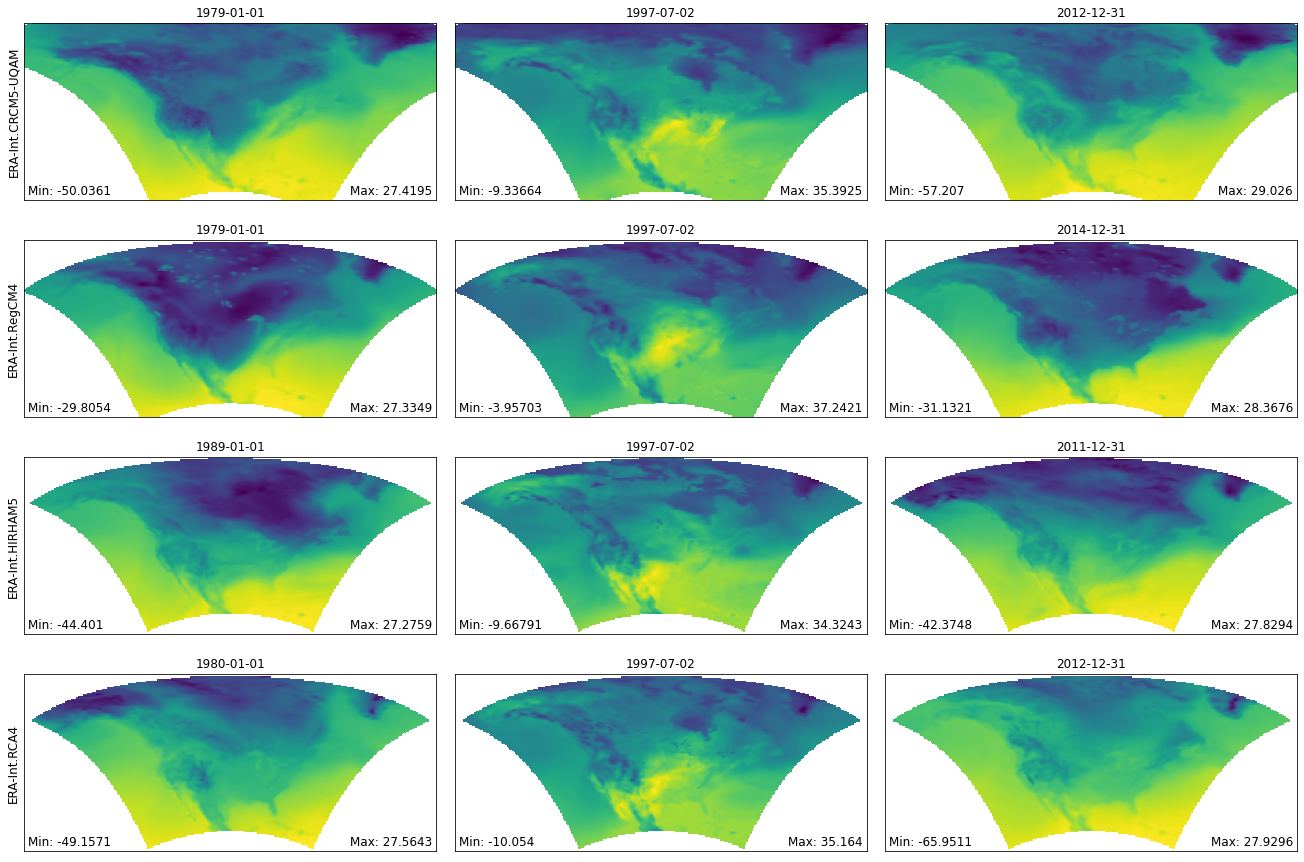

CPU times: user 4.8 s, sys: 346 ms, total: 5.15 s
Wall time: 1min 16s


In [31]:
%%time

# Plot using the Zarr Store obtained from an earlier step in the notebook.
figure = plot_first_mid_last(ds, data_var)

plt.show()

#### Optional: save figure to a PNG file

Change the value of SAVE_PLOT to True to produce a PNG file of the plot.   The file will be saved in the same folder as this notebook.

Then use Jupyter's file browser to locate the file and right-click the file to download it.   

In [34]:
SAVE_PLOT = False
if SAVE_PLOT:
    plotfile = f'./{dataset_key}_FML.png'
    figure.savefig(plotfile, dpi=100)

### Create Statistical Map Plots for Several Output Runs (more compute intensive)

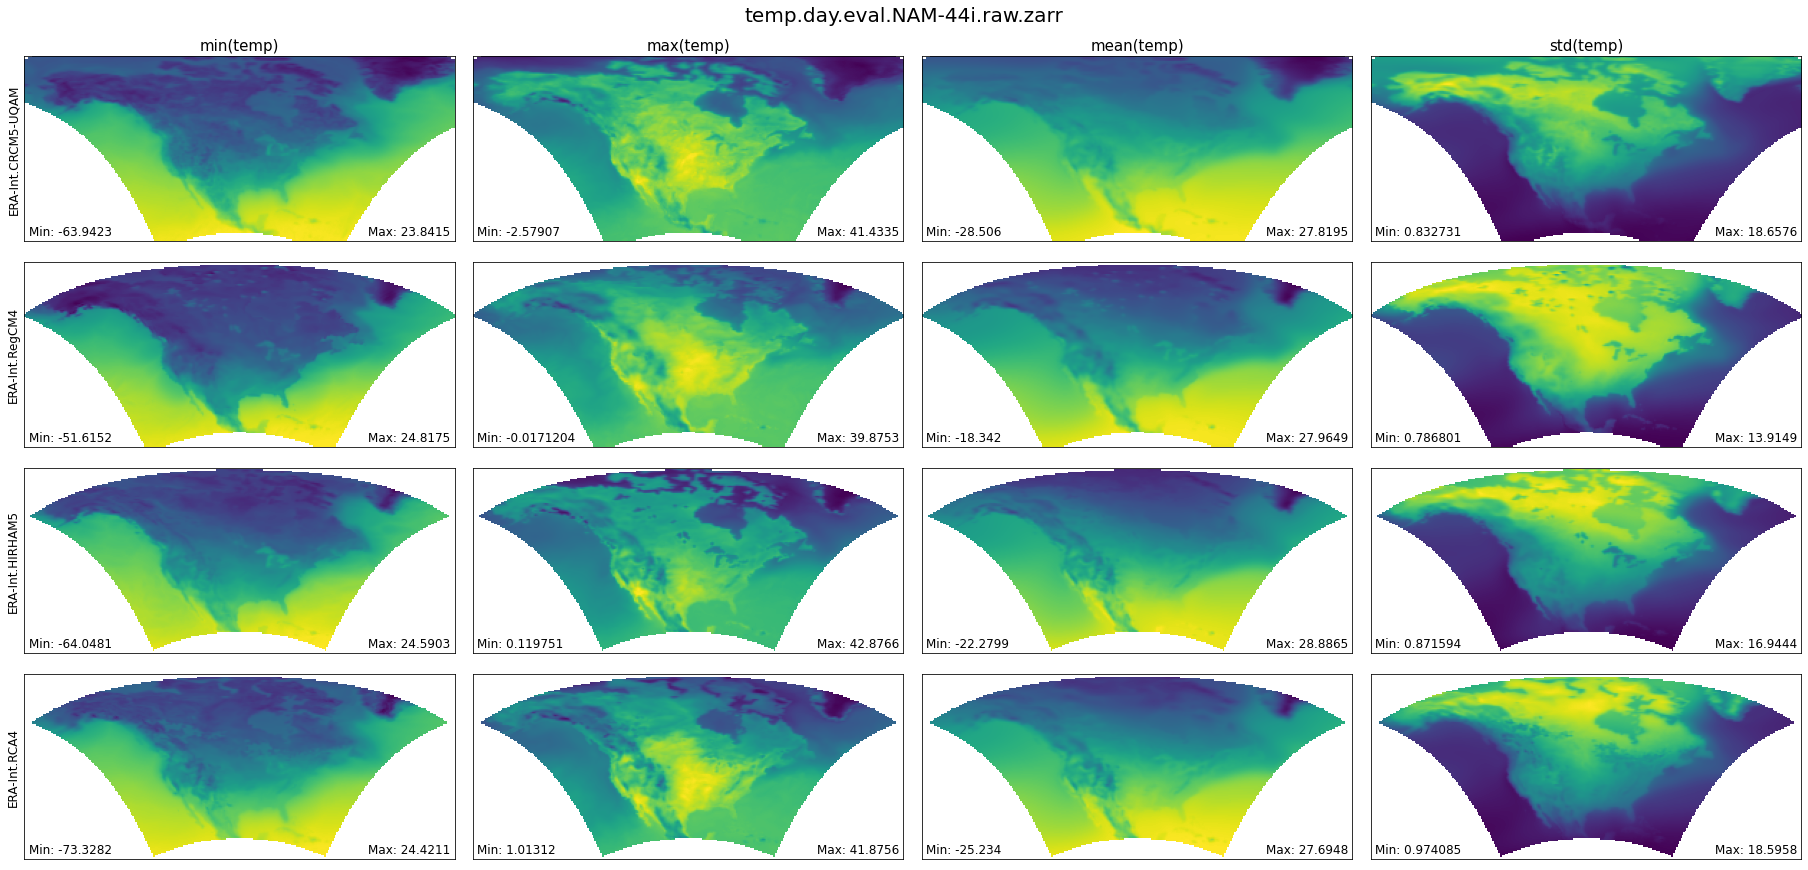

CPU times: user 19.7 s, sys: 1.44 s, total: 21.2 s
Wall time: 4min 18s


In [35]:
%%time

# Plot using the Zarr Store obtained from an earlier step in the notebook.
store_name = dataset_key + ".zarr"
figure = plot_stat_maps(ds, data_var, store_name)

plt.show()

#### Optional: save figure to a PNG file

Change the value of SAVE_PLOT to True to produce a PNG file of the plot.   The file will be saved in the same folder as this notebook.

Then use Jupyter's file browser to locate the file and right-click the file to download it.   

In [40]:
SAVE_PLOT = False
if SAVE_PLOT:
    plotfile = f'./{dataset_key}_MAPS.png'
    figure.savefig(plotfile, dpi=100)

### Plot Time Series for Several Output Runs (more compute intensive)

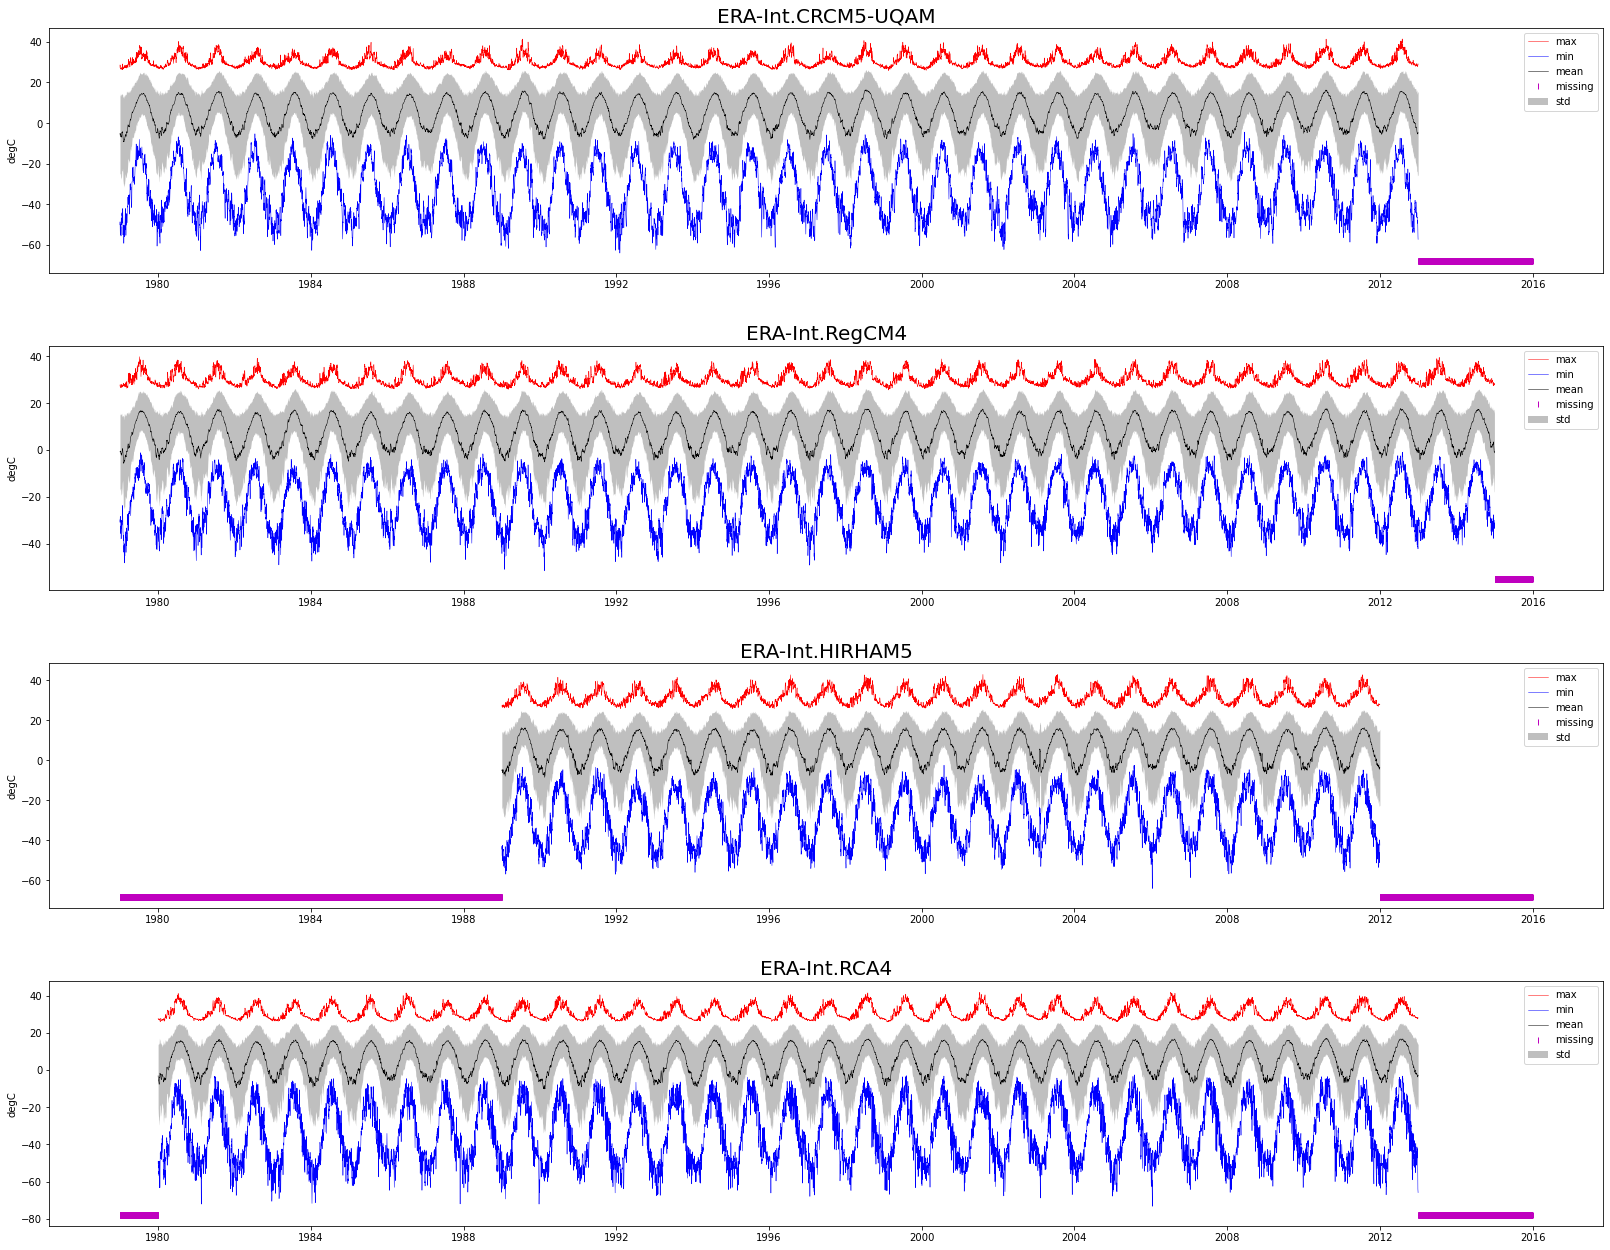

CPU times: user 32.1 s, sys: 2.36 s, total: 34.5 s
Wall time: 6min 34s


In [37]:
%%time

# Plot using the Zarr Store obtained from an earlier step in the notebook.
figure = plot_timeseries(ds, data_var)

plt.show()

#### Optional: save figure to a PNG file

Change the value of SAVE_PLOT to True to produce a PNG file of the plot.   The file will be saved in the same folder as this notebook.

Then use Jupyter's file browser to locate the file and right-click the file to download it.   

In [38]:
SAVE_PLOT = False
if SAVE_PLOT:
    plotfile = f'./{dataset_key}_TS.png'
    figure.savefig(plotfile, dpi=100)

### Release the workers.

In [ ]:
!date

In [39]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
